# Example reduction

In [1]:
import os
import sys

sys.path.append(os.path.expanduser('~/git/LiquidsReflectometer/reduction'))

import matplotlib.lines as mlines
import numpy as np
from matplotlib import pyplot as plt

#%matplotlib notebook
%matplotlib ipympl

import warnings

warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

In [4]:
import mantid
import mantid.simpleapi as api

mantid.kernel.config.setLogLevel(3)

ConfigService-[Error] logging set to PRIO_ERROR priority


In [5]:
print(mantid.__version__)
print(sys.version)

6.3.0
3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]


In [6]:
import importlib

from lr_reduction import event_reduction, template


ths = 0.499919, tthd = 0.999199


(100.0, 180.0)

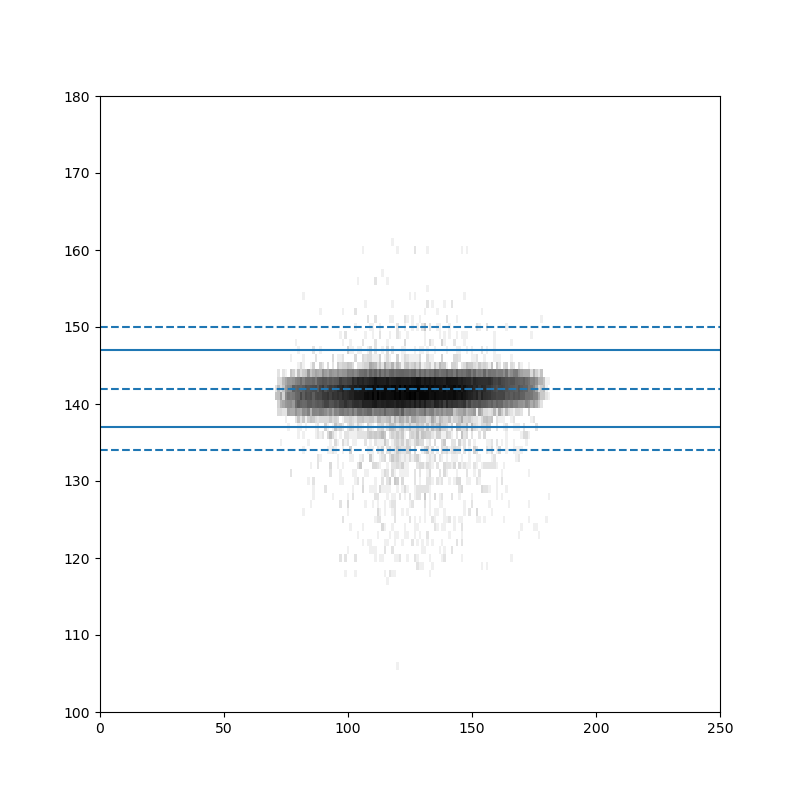

In [8]:
# DB: 200686, center at 141.6
# REF: 200649, center at 141.6, ths = 0.499919, tthd = 0.999199
run_number = 200651
template_path = '/SNS/REF_L/IPTS-30101/shared/autoreduce/template_div_200651.xml'

run_number = 200649
template_path = '/SNS/REF_L/IPTS-30101/shared/autoreduce/template_div_200649.xml'

sequence_number = 1
template_data = template.read_template(template_path, sequence_number)


ws_sc = api.LoadEventNexus("REF_L_%s" % run_number)
ths_value = ws_sc.getRun()['ths'].value[0]
tthd_value = ws_sc.getRun()['tthd'].value[0]
print("ths = %g, tthd = %g" % (ths_value, tthd_value))
tof_min = ws_sc.getTofMin()
tof_max = ws_sc.getTofMax()
_ws = api.Rebin(InputWorkspace=ws_sc, Params="%s,200,%s" % (tof_min, tof_max))
y=_ws.extractY()
x=_ws.extractX()
y = np.reshape(y, (256, 304, y.shape[1]))

_x_vs_y = np.sum(y, axis=2)

fig, ax = plt.subplots(figsize=(8,8))
im = ax.pcolormesh(np.arange(256), np.arange(304), np.log(_x_vs_y.T), cmap="Greys")
l = mlines.Line2D([0, 304], [template_data.data_peak_range[0], template_data.data_peak_range[0]], linestyle='-')
ax.add_line(l)
l = mlines.Line2D([0, 304], [template_data.data_peak_range[1], template_data.data_peak_range[1]], linestyle='-')
ax.add_line(l)
l = mlines.Line2D([0, 304], [template_data.background_roi[0], template_data.background_roi[0]], linestyle='--')
ax.add_line(l)
l = mlines.Line2D([0, 304], [template_data.background_roi[1], template_data.background_roi[1]], linestyle='--')
ax.add_line(l)

center = np.sum(template_data.data_peak_range)/2.0
l = mlines.Line2D([0, 304], [center, center], linestyle='--')
ax.add_line(l)

ax.set_xlim([0,250])
ax.set_ylim([100,180])

In [9]:
from lmfit.models import GaussianModel, LinearModel, QuadraticModel, RectangleModel


def process_data(workspace, summed=True, tof_step=200):
    tof_min = workspace.getTofMin()
    tof_max = workspace.getTofMax()
    _ws = api.Rebin(InputWorkspace=workspace, Params="%s,%s,%s" % (tof_min, tof_step, tof_max))
    y=_ws.extractY()
    y = np.reshape(y, (256, 304, y.shape[1]))

    tof=_ws.extractX()[0]
    tof = (tof[:-1]+tof[1:])/2.0


    if summed:
        y = np.sum(y, axis=2)

    _y = np.sum(y, axis=0)
    _x = np.arange(304)
    return tof, _x, _y

def fit_signal_flat_bck(x, y, x_min=110, x_max=170, center=None, sigma=None):
    gauss = GaussianModel(prefix='g_')
    linear = LinearModel(prefix='l_')
    QuadraticModel(prefix='q_')
    RectangleModel(prefix='r_')

    amplitude_guess = np.max(y[x_min:x_max])

    _center = 140
    _sigma = 2
    if center is not None:
        _center = center
    if sigma is not None:
        _sigma = sigma

    pars = gauss.make_params(amplitude=amplitude_guess, center=_center, sigma=_sigma)
    pars.update(linear.make_params(a=0, b=0))

    #if center is not None:
    #    pars['g_center'].vary=False
    if sigma is not None:
        pars['g_sigma'].vary=False
    pars['g_amplitude'].min=0
    pars['g_center'].min=_center-2
    pars['g_center'].max=_center+2

    weights=1/np.sqrt(y)
    weights[y<1]=1

    model = gauss + linear
    fit = model.fit(y[x_min:x_max], pars, method='leastsq',
                    x=x[x_min:x_max],
                    weights=1/weights[x_min:x_max])
    #print(fit.fit_report())

    fit.params['g_amplitude']
    c=fit.params['g_center']
    width=fit.params['g_sigma']
    # print("Gaussian: \t %5.4g +- %5.4g \t %3.3g +- %3.3g \t %3.3g +- %3.3g" %
    #       (a.value, a.stderr, c.value, c.stderr, width.value, width.stderr))
    return c, width, fit




Center: 141.618	 Width: 1.59029 [136 148]


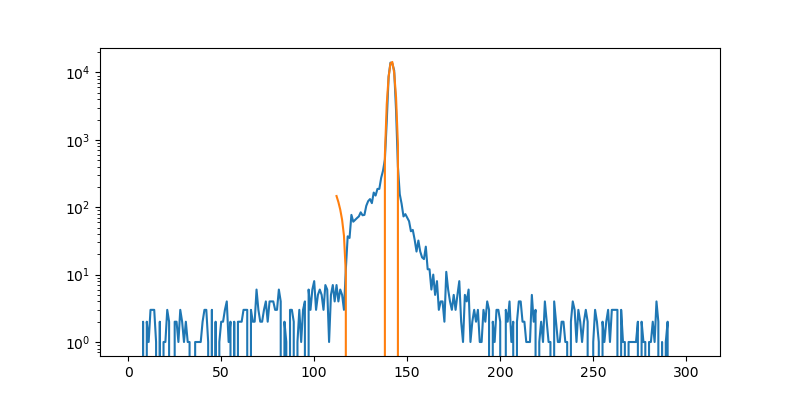

In [10]:
x_min=template_data.data_peak_range[0]-25
x_max=template_data.data_peak_range[1]+25

tof, _x, _y = process_data(ws_sc, summed=True, tof_step=200)

peak_center = np.argmax(_y)
center, width, fit = fit_signal_flat_bck(_x, _y, x_min=x_min, x_max=x_max, center=peak_center)
print("Center: %g\t Width: %g [%g %g]" % (center, width, np.ceil(center-4*width), np.ceil(center+4*width)))

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(_x, _y)
plt.plot(_x[x_min:x_max], fit.best_fit)

plt.yscale('log')

# Reduction


200649
wl=4.9; ths=0.499919; thi=6.08883e-06; No offset
Background on both sides: [134 136] [148 150]
wl=4.9; ths=0.499919; thi=6.08883e-06; No offset
Qz range:  0.01506781772290608 0.016922469806795286 0.018777121890684496
Background on both sides: [134 136] [148 150]
Summing threshold: 0.0169225
wl=4.9; ths=0.499919; thi=6.08883e-06; No offset
Qz range:  0.01506781772290608 0.016922469806795286 0.018777121890684496
Background on both sides: [134 136] [148 150]


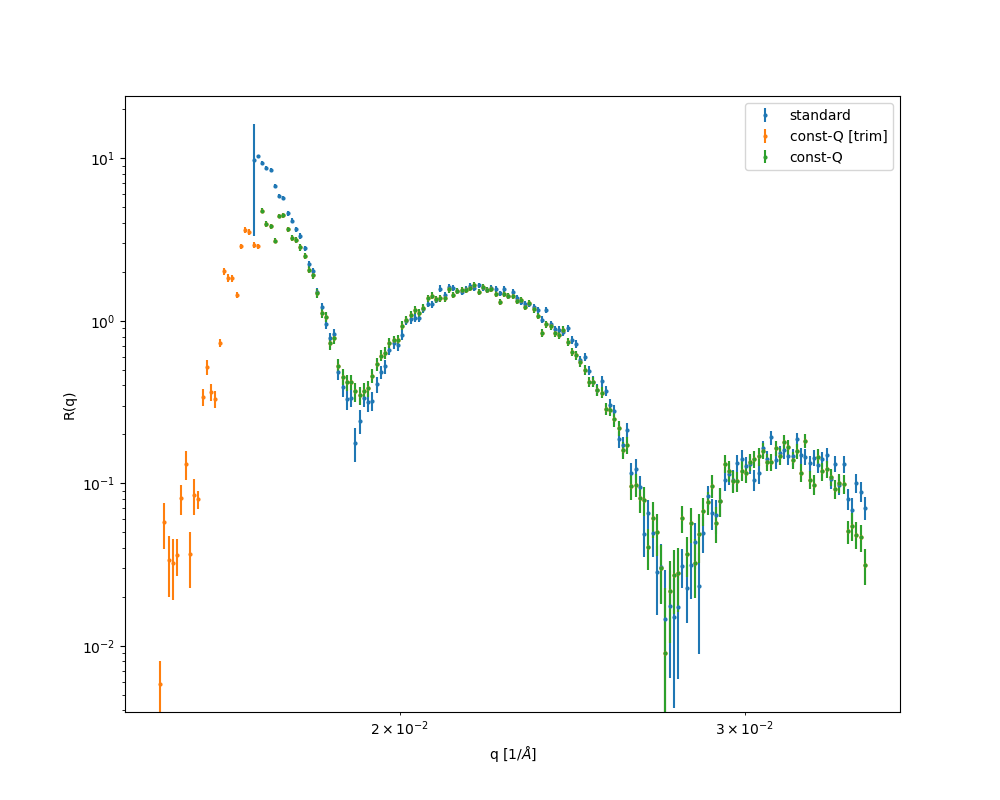

In [19]:
importlib.reload(template)
importlib.reload(event_reduction)

data_dir = os.path.expanduser('~/git/LiquidsReflectometer/reduction/data')
template_path = '/SNS/REF_L/IPTS-30101/shared/autoreduce/template_div_200649.xml'

#qz_mid, refl, d_refl = template.process_from_template(run_number, template_path)
pre_cut = 1
post_cut = 1

qz_all = []
refl_all = []
d_refl_all = []

first_run = None

fig, ax = plt.subplots(figsize=(10,8))


#template_data.data_peak_range = [141-5, 142+5]

print('\n%s' % run_number)
ws_sc = api.Load("REF_L_%s" % run_number)
qz_mid, refl, d_refl = template.process_from_template_ws(ws_sc, template_data)
qz_mid2, refl2, d_refl2 = template.process_from_template_ws(ws_sc, template_data, q_summing=True, tof_weighted=True, clean=True)
qz_mid3, refl3, d_refl3 = template.process_from_template_ws(ws_sc, template_data, q_summing=True, tof_weighted=True, clean=False)

plt.errorbar(qz_mid, refl, yerr=d_refl, markersize=4, marker='.', linestyle='', label='standard')
plt.errorbar(qz_mid3, refl3, yerr=d_refl3, markersize=4, marker='.', linestyle='', label='const-Q [trim]')
plt.errorbar(qz_mid2, refl2, yerr=d_refl2, markersize=4, marker='.', linestyle='', label='const-Q')



plt.legend()
plt.xlabel(r'q [$1/\AA$]')
plt.ylabel('R(q)')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

